In [1]:
# Basics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.core.common import random_state

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.layers as layers
from tensorflow.keras.utils import to_categorical


# Graphing Style
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Cleaning and Exploratory  Data Analysis

In [3]:
face = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/face.csv")

In [4]:
face.shape

(28709, 2)

In [5]:
face["pixels"] = face.pixels.apply(lambda x: np.array(tuple(map(int, x.split()))))

In [6]:
face.head()

,emotion,pixels
0,0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4..."
1,0,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ..."
2,2,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ..."
3,4,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2..."
4,6,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23..."


In [7]:
emo_di = {0: "Angry", 1:"Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}

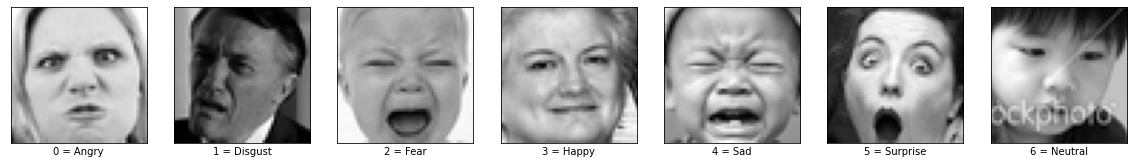

In [8]:
plt.figure(figsize = (20,20))
start_index = 0
for i in range(7):
    plt.subplot(1,7,i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(face[face.emotion == i].pixels.iloc[20].reshape(48,48), cmap="gray")
    plt.xlabel("{} = {}".format(i, emo_di[i]))

In [9]:
face.emotion.value_counts()

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

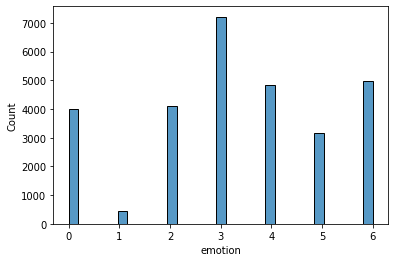

In [10]:
sns.histplot(face.emotion)

In [11]:
train, test = train_test_split(face, train_size=0.6, random_state=1)
val, test = train_test_split(test, test_size=0.5, random_state=1)

# Oversample and subsample
faces_balanced = None
for i in range(7):
    if faces_balanced is None:
        faces_balanced = face[face.emotion == i].sample(n=3000, replace=True, random_state=100)
    else:
        faces_balanced = pd.concat([faces_balanced, face[face.emotion == i].sample(n=3000, replace=True, random_state=100)], sort = False)
faces_balanced = faces_balanced.sample(frac=1, random_state=49)

train_x = np.concatenate(np.asarray(faces_balanced["pixels"])).reshape(-1, 48 * 48)
val_x = np.concatenate(np.asarray(val["pixels"])).reshape(-1, 48 * 48)
test_x = np.concatenate(np.asarray(test["pixels"])).reshape(-1, 48 * 48)
train_y = faces_balanced.emotion
val_y = val.emotion
test_y = test.emotion

x_mean = np.mean(train_x)
x_std = np.std(train_x) + 1e-10
train_x = (train_x - x_mean) / x_std
val_x = (val_x - x_mean) / x_std
test_x = (test_x - x_mean) / x_std

In [12]:
train_y.value_counts()

4    3000
5    3000
2    3000
0    3000
1    3000
3    3000
6    3000
Name: emotion, dtype: int64

In [13]:
val_y.value_counts()

3    1420
6    1035
4     963
0     811
2     796
5     625
1      92
Name: emotion, dtype: int64

In [14]:
test_y.value_counts()

3    1494
6     976
4     946
2     833
0     792
5     627
1      74
Name: emotion, dtype: int64

# Modeling

## Naive Bayes

In [15]:
nb = GaussianNB()
nb.fit(train_x, train_y)

GaussianNB()

In [16]:
nb.score(train_x, train_y)

0.23157142857142857

In [17]:
nb.score(val_x, val_y)

0.20358760013932428

In [18]:
nb.score(test_x, test_y)

0.20968303726924417

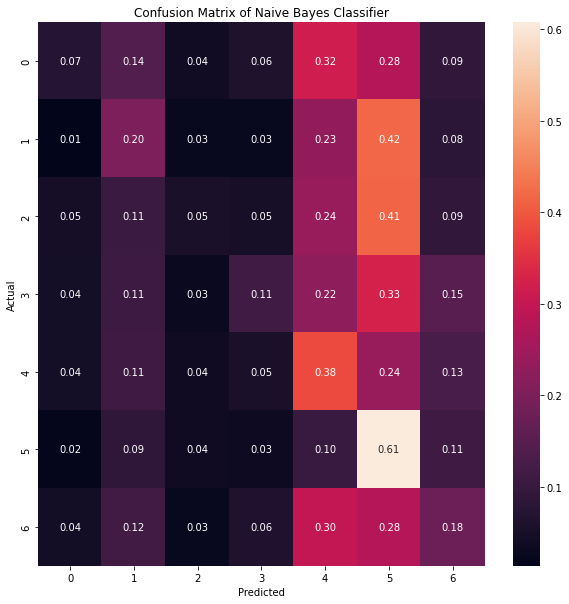

In [19]:
cm = confusion_matrix(test_y, nb.predict(test_x))
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.title('Confusion Matrix of Naive Bayes Classifier')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## Logistic Regression

In [20]:
lr = LogisticRegression(penalty='l2', tol=0.1, solver='saga')
lr.fit(train_x, train_y)

LogisticRegression(solver='saga', tol=0.1)

In [21]:
lr.score(train_x, train_y)

0.4888571428571429

In [22]:
lr.score(val_x, val_y)

0.36363636363636365

In [23]:
lr.score(test_x, test_y)

0.36450714036920934

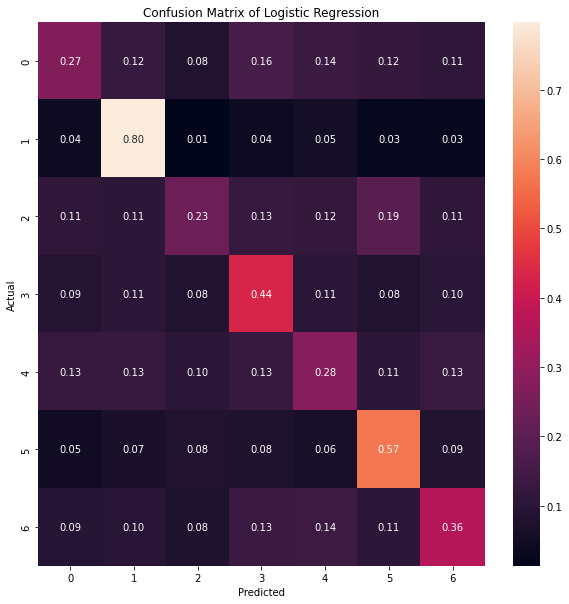

In [24]:
cm = confusion_matrix(test_y, lr.predict(test_x))
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.title('Confusion Matrix of Logistic Regression')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## K-Means + Logistic Regression

In [25]:
pl = Pipeline([
    ("kmeans", KMeans(n_clusters=35)),
    ("logisreg", LogisticRegression(penalty='none', tol=0.1, solver='saga'))
])

In [26]:
pl.fit(train_x, train_y)

Pipeline(steps=[('kmeans', KMeans(n_clusters=35)),
                ('logisreg',
                 LogisticRegression(penalty='none', solver='saga', tol=0.1))])

In [27]:
pl.score(train_x, train_y)

0.2277142857142857

In [28]:
pl.score(val_x, val_y)

0.19696969696969696

In [29]:
pl.score(test_x, test_y)

0.1966213862765587

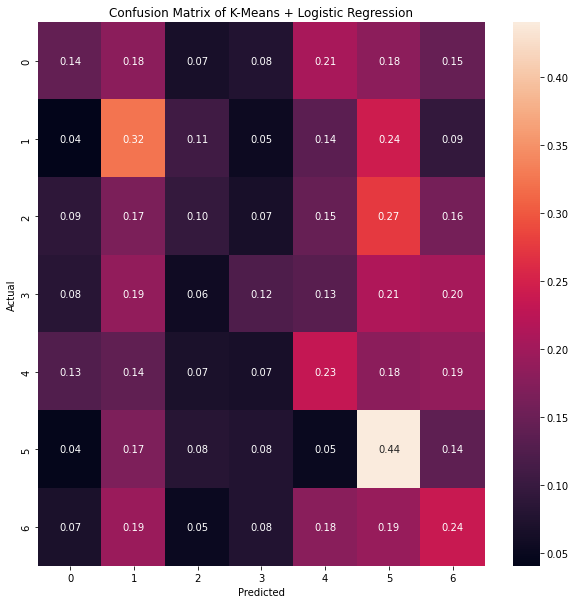

In [30]:
cm = confusion_matrix(test_y, pl.predict(test_x))
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.title('Confusion Matrix of K-Means + Logistic Regression')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## KNN with PCA + CV

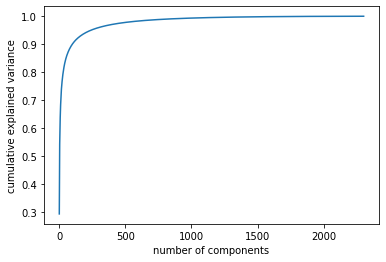

In [31]:
pca = PCA().fit(train_x)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [32]:
pl1 = Pipeline([
    ("PCA", PCA(n_components=100)),
    ("knn", KNeighborsClassifier())
])
params = {"knn__n_neighbors": [1, 3, 5, 7, 12, 15, 20]}
grids = GridSearchCV(pl1, params, cv=5)
grids.fit(train_x, train_y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('PCA', PCA(n_components=100)),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 3, 5, 7, 12, 15, 20]})

In [33]:
grids.best_params_

{'knn__n_neighbors': 1}

In [34]:
grids.best_score_

0.6629047619047619

In [35]:
grids.best_estimator_.score(val_x, val_y)

0.6461163357715082

In [36]:
grids.best_estimator_.score(test_x, test_y)

0.6379310344827587

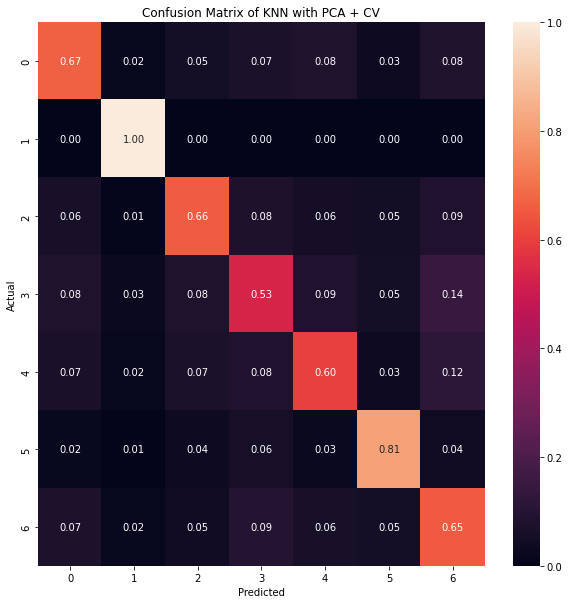

In [37]:
cm = confusion_matrix(test_y, grids.best_estimator_.predict(test_x))
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.title('Confusion Matrix of KNN with PCA + CV')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## Random Forest

In [38]:
rfc = RandomForestClassifier(max_depth=5)
rfc.fit(train_x, train_y)

RandomForestClassifier(max_depth=5)

In [39]:
rfc.score(train_x, train_y)

0.4005714285714286

In [40]:
rfc.score(val_x, val_y)

0.2871821664925113

In [41]:
rfc.score(test_x, test_y)

0.28126088470916055

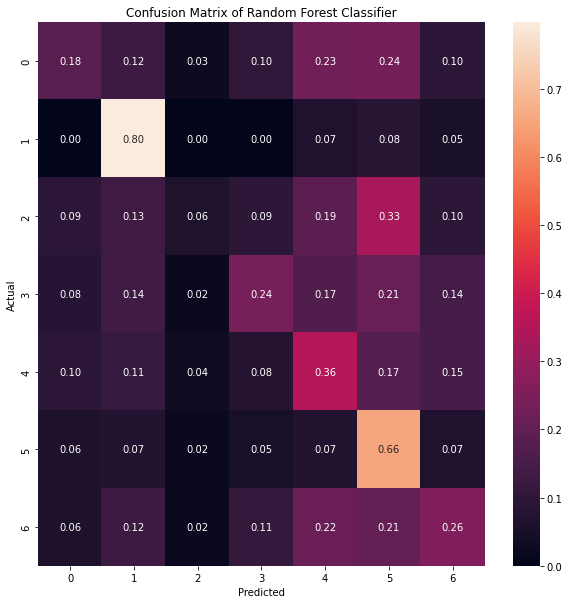

In [42]:
cm = confusion_matrix(test_y, rfc.predict(test_x))
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.title('Confusion Matrix of Random Forest Classifier')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## Support Vector Machine with PCA

In [43]:
pl2 = Pipeline([
               ("PCA", PCA(n_components=50)),
               ("svm", SVC())
])
pl2.fit(train_x, train_y)

Pipeline(steps=[('PCA', PCA(n_components=50)), ('svm', SVC())])

In [44]:
pl2.score(train_x, train_y)

0.6312857142857143

In [45]:
pl2.score(val_x, val_y)

0.45942180424939044

In [46]:
pl2.score(test_x, test_y)

0.46900034831069315

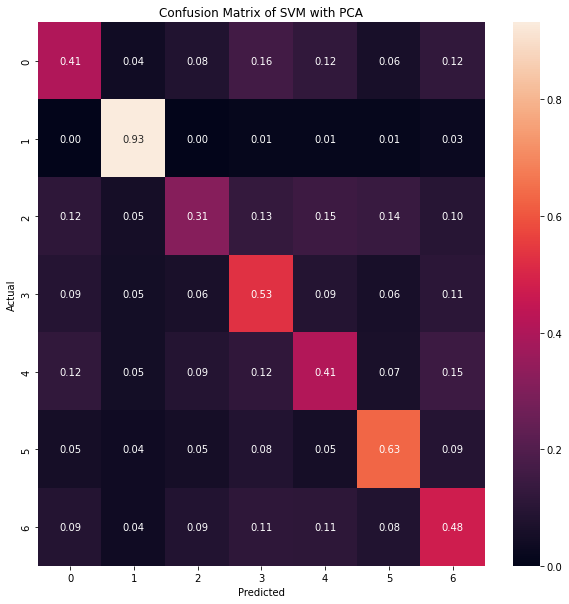

In [47]:
cm = confusion_matrix(test_y, pl2.predict(test_x))
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.title('Confusion Matrix of SVM with PCA')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## Artificial Neural Network

In [48]:
train_y_cat = to_categorical(train_y)
val_y_cat = to_categorical(val_y)
test_y_cat = to_categorical(test_y)

In [49]:
model = Sequential()
model.add(Dense(256, activation = 'relu', input_shape = (48 * 48,)))
model.add(layers.Dropout(0.2))
model.add(Dense(256, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(Dense(7, activation = 'softmax'))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               590080    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 657,671
Trainable params: 657,671
Non-trainable params: 0
_________________________________________________________________


In [50]:
history = model.fit(train_x, train_y_cat, epochs = 20, validation_data = (val_x, val_y_cat))

Epoch 1/20
657/657 [==============================] - 3s 4ms/step - loss: 1.9979 - accuracy: 0.2342 - val_loss: 1.7877 - val_accuracy: 0.2896
Epoch 2/20
657/657 [==============================] - 2s 3ms/step - loss: 1.7601 - accuracy: 0.3051 - val_loss: 1.6930 - val_accuracy: 0.3260
Epoch 3/20
657/657 [==============================] - 2s 3ms/step - loss: 1.6622 - accuracy: 0.3450 - val_loss: 1.6524 - val_accuracy: 0.3419
Epoch 4/20
657/657 [==============================] - 2s 3ms/step - loss: 1.5882 - accuracy: 0.3782 - val_loss: 1.6124 - val_accuracy: 0.3476
Epoch 5/20
657/657 [==============================] - 2s 3ms/step - loss: 1.5259 - accuracy: 0.3974 - val_loss: 1.5918 - val_accuracy: 0.3640
Epoch 6/20
657/657 [==============================] - 2s 3ms/step - loss: 1.4710 - accuracy: 0.4197 - val_loss: 1.5349 - val_accuracy: 0.3824
Epoch 7/20
657/657 [==============================] - 2s 3ms/step - loss: 1.4237 - accuracy: 0.4397 - val_loss: 1.5554 - val_accuracy: 0.3821
Epoch 

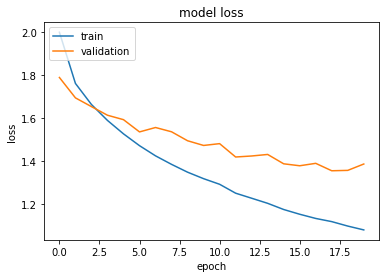

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

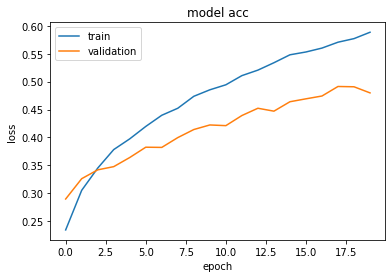

In [52]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [53]:
model.evaluate(test_x, test_y_cat)

180/180 [==============================] - 0s 2ms/step - loss: 1.3736 - accuracy: 0.4866


[1.3736388683319092, 0.48659002780914307]

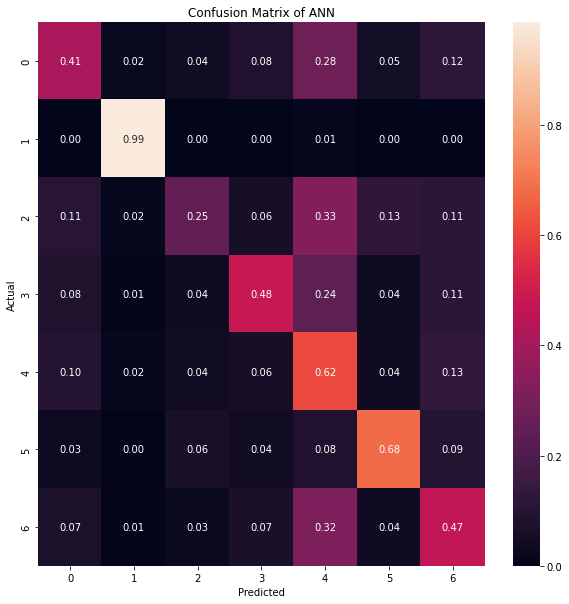

In [54]:
cm = confusion_matrix(test_y, np.apply_along_axis(np.argmax, 1, model.predict(test_x)))
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.title('Confusion Matrix of ANN')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## Convolutional Neural Network

In [55]:
train_x_cnn = train_x.reshape(-1, 48, 48, 1)
val_x_cnn = val_x.reshape(-1, 48, 48, 1)
test_x_cnn = test_x.reshape(-1, 48, 48, 1)

In [56]:
model2 = Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Dropout(0.5))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(7))

In [57]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 dropout_2 (Dropout)         (None, 21, 21, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 10, 10, 64)       

In [58]:
history2 = model2.fit(train_x_cnn, train_y, epochs = 20, validation_data = (val_x_cnn, val_y))

Epoch 1/20
657/657 [==============================] - 13s 19ms/step - loss: 1.8835 - accuracy: 0.2175 - val_loss: 1.8248 - val_accuracy: 0.3095
Epoch 2/20
657/657 [==============================] - 14s 22ms/step - loss: 1.7397 - accuracy: 0.3118 - val_loss: 1.7198 - val_accuracy: 0.3459
Epoch 3/20
657/657 [==============================] - 14s 22ms/step - loss: 1.6333 - accuracy: 0.3683 - val_loss: 1.6342 - val_accuracy: 0.3865
Epoch 4/20
657/657 [==============================] - 14s 22ms/step - loss: 1.5578 - accuracy: 0.3953 - val_loss: 1.5656 - val_accuracy: 0.4112
Epoch 5/20
657/657 [==============================] - 14s 22ms/step - loss: 1.5071 - accuracy: 0.4158 - val_loss: 1.5021 - val_accuracy: 0.4613
Epoch 6/20
657/657 [==============================] - 14s 22ms/step - loss: 1.4568 - accuracy: 0.4378 - val_loss: 1.4215 - val_accuracy: 0.4767
Epoch 7/20
657/657 [==============================] - 14s 22ms/step - loss: 1.4209 - accuracy: 0.4530 - val_loss: 1.4112 - val_accuracy:

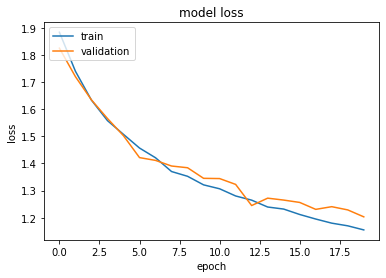

In [59]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

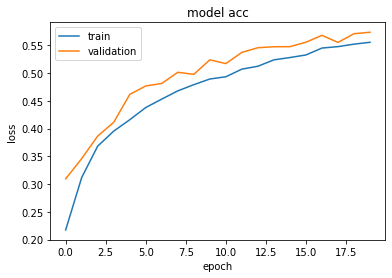

In [60]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [61]:
model2.evaluate(test_x_cnn, test_y)

180/180 [==============================] - 1s 4ms/step - loss: 1.2005 - accuracy: 0.5705


[1.2005456686019897, 0.5705329179763794]

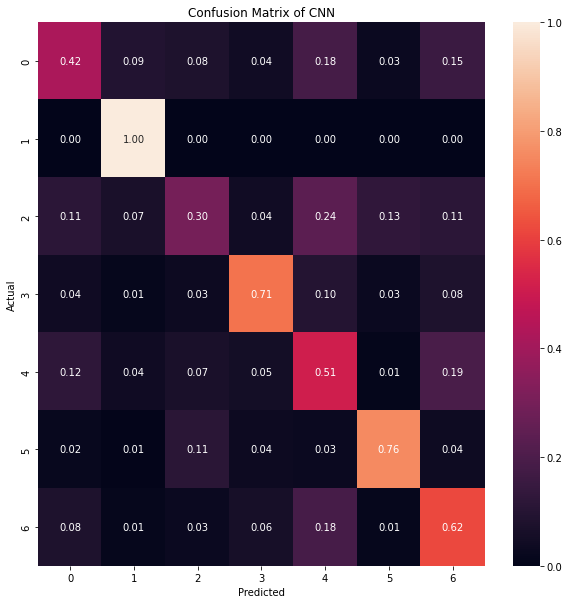

In [62]:
cm = confusion_matrix(test_y, np.apply_along_axis(np.argmax, 1, model2.predict(test_x_cnn)))
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.title('Confusion Matrix of CNN')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [63]:
model.save('saved_model/ann.h5')
model2.save('saved_model/cnn.h5')